In [1]:
import numpy as np
from scipy.interpolate import interp1d

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Freeman & Fried (2011), Fig. 2

In [2]:
# Data extracted from Fig. 2 of Freeman & Fried (2011)
freeman = dict()

freeman['norm_resp'] = dict()
freeman['norm_resp']['2'] = np.array([1.00000, 1.00000, 2.02247, 0.71475,
                                        2.98876, 0.68852, 3.95506, 0.65902,
                                        4.94382, 0.63934, 5.91011, 0.62623,
                                        6.89888, 0.62951, 7.88764, 0.62951,
                                        8.87640, 0.62623, 9.86517, 0.61311]).reshape((-1, 2))
freeman['norm_resp']['4'] = np.array([1.00000, 1.00000, 1.97753, 0.69836,
                                        2.98876, 0.60656, 3.95506, 0.58361,
                                        4.92135, 0.54098, 5.91011, 0.52787,
                                        6.89888, 0.53443, 7.93258, 0.52131,
                                        8.89888, 0.51148, 9.86517, 0.51148]).reshape((-1, 2))
freeman['norm_resp']['8'] = np.array([1.00000, 1.00000, 1.97753, 0.59672,
                                        3.03371, 0.52787, 3.97753, 0.47869,
                                        4.94382, 0.43607, 5.93258, 0.43279,
                                        6.92135, 0.40984, 7.88764, 0.37377,
                                        8.87640, 0.38689, 9.86517, 0.36721]).reshape((-1, 2))
freeman['norm_resp']['16'] = np.array([1.03371, 0.98361, 2.00000, 0.66557,
                                         2.98876, 0.48525, 3.97753, 0.42295,
                                         4.96629, 0.37049, 5.93258, 0.32787,
                                         6.92135, 0.31475, 7.93258, 0.29508,
                                         8.87640, 0.28197, 9.91011, 0.28197]).reshape((-1, 2))

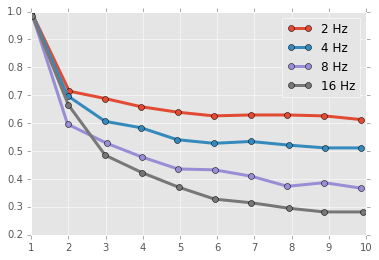

In [3]:
for cond in ['2', '4', '8', '16']:
    plt.plot(freeman['norm_resp'][cond][:, 0], freeman['norm_resp'][cond][:, 1], 'o-',
             linewidth=3, label=cond + ' Hz')
plt.legend()

# Functions
-----------------

Following are all utily funcions used in this script.

In [4]:
from scipy.signal import fftconvolve

class HorsagerModel(object):
    def __init__(self, tsample, at_thresh=True):
        self.tsample = tsample
        self.at_thresh = at_thresh
        
        # Fast response
        tau1 = 0.42 / 1000
        t = np.arange(0, 10 * tau1, self.tsample)
        self.gamma1 = e2cm.gamma(1, tau1, t)
        
        # Desensitization
        self.eps_thresh = 2.25
        self.eps_suprathresh = 8.73
        tau2 = 45.25 / 1000
        t = np.arange(0, 10 * tau2, self.tsample)
        self.gamma2 = e2cm.gamma(2, tau2, t)
        
        # Nonlinearity
        self.beta_thresh = 3.43
        self.beta_suprathresh = 0.83
        
        # Slow response
        tau3 = 26.25 / 1000
        t = np.arange(0, 10 * tau3, self.tsample)
        self.gamma3 = e2cm.gamma(1, tau3, t)
        
    def model_cascade(self, ecm, dolayers, dojit=True):
        sz = ecm[0].data.size
        r1 = self.tsample * fftconvolve(ecm[0].data, self.gamma1, mode='full')[:sz]
        ca = self.tsample * np.cumsum(np.maximum(0, -ecm[0].data))
        
        if self.at_thresh:
            eps = self.eps_thresh
            beta = self.beta_thresh
        else:
            eps = self.eps_suprathresh
            beta = self.beta_suprathresh
        r2 = r1 - eps * self.tsample * fftconvolve(ca, self.gamma2, mode='full')[:sz]
        r3 = np.maximum(0, r2) ** beta
        r4 = self.tsample * fftconvolve(r3, self.gamma3, mode='full')[:sz]
        
        return utils.TimeSeries(ecm[0].tsample, r4)

In [5]:
def horsager2percept(stim, implant, retina, use_ecs=True, at_thresh=True):
    # Check type to avoid backwards compatibility issues
    if not isinstance(implant, e2cm.ElectrodeArray):
        raise TypeError("`implant` must be of type ec2b.ElectrodeArray")

    rsample = 1
    dojit = True
    dolayers = ['NFL']
    tol = 0.05

    
    # Parse `stim` (either single pulse train or a list/dict of pulse trains),
    # and generate a list of pulse trains, one for each electrode
    pt_list = ec2b.parse_pulse_trains(stim, implant)

    # Generate a standard temporal model if necessary
    tm = HorsagerModel(pt_list[0].tsample, at_thresh)

    # Derive the effective current spread
    if use_ecs:
        ecs, _ = retina.electrode_ecs(implant)
    else:
        _, ecs = retina.electrode_ecs(implant)

    # `ecs_list` is a pixel by `n` list where `n` is the number of layers
    # being simulated. Each value in `ecs_list` is the current contributed
    # by each electrode for that spatial location
    ecs_list = []
    idx_list = []
    for xx in range(retina.gridx.shape[1]):
        for yy in range(retina.gridx.shape[0]):
            # If any of the used current spread maps at [yy, xx] are above
            # tolerance, we need to process that pixel
            process_pixel = False
            if 'INL' in dolayers:
                layer = ecs[yy, xx, 0, :]
                process_pixel |= np.any(layer >= tol * layer.max())
            if 'NFL' in dolayers:
                layer = ecs[yy, xx, 1, :]
                process_pixel |= np.any(layer >= tol * layer.max())

            if process_pixel:
                ecs_list.append(ecs[yy, xx])
                idx_list.append([yy, xx])

    pt_arr = np.array([p.data for p in pt_list])
    
    sr_list = utils.parfor(ec2b.calc_pixel, ecs_list, n_jobs=-1, engine='joblib',
                           func_args=[pt_arr, tm, rsample, dolayers, dojit])

    bm = np.zeros(retina.gridx.shape + (sr_list[0].data.shape[-1], ))
    idxer = tuple(np.array(idx_list)[:, i] for i in range(2))
    bm[idxer] = [sr.data for sr in sr_list]
    return utils.TimeSeries(sr_list[0].tsample, bm)

In [6]:
class GanglionCellResponse(ec2b.TemporalModel):
    def __init__(self, tsample, tau_inl=18.0 / 1000, delay_inl=40.0 / 1000,
                 lweight=0.636):
        super(GanglionCellResponse, self).__init__(tsample, tau_inl=tau_inl,
                                                   delay_inl=delay_inl,
                                                   lweight=lweight)
        
    def stationary_nonlinearity(self, resp):
        return resp
    
    def slow_response(self, resp):
        return resp

In [7]:
implant = e2cm.ElectrodeArray('epiretinal', 40.0 / 2, -500, -500, 25.0)

r_sampling = 100
axon_lambda = 2 
retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                     xlo=implant[0].x_center, xhi=implant[0].x_center,
                     ylo=implant[0].y_center, yhi=implant[0].y_center)

In [8]:
pdur = 1.0 / 1000
tsample = 0.005 / 1000
amp = 20

In [9]:
delay_inl = 40.0 / 1000
tau_inl = 1.0 / 1000
lweight = 0.636
ecs_scale = 1.0
tm = GanglionCellResponse(tsample=tsample, delay_inl=delay_inl,
                          tau_inl=tau_inl, lweight=lweight)

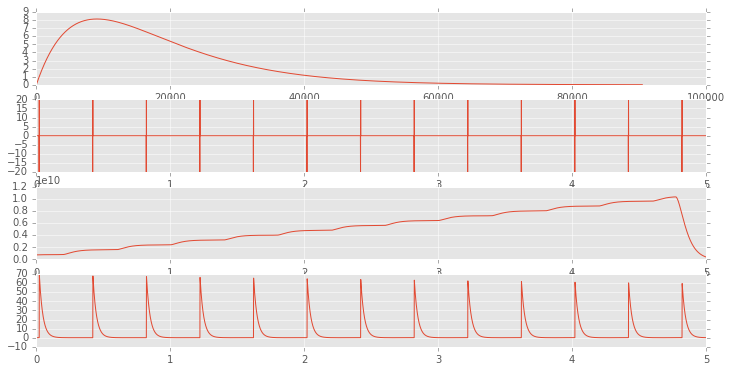

In [11]:
plt.figure(figsize=(12, 6))

tau2 = 45.25 / 1000
tgamma2 = np.arange(0, 10 * tau2, tsample)
gamma2 = e2cm.gamma(2, tau2, tgamma2)
plt.subplot(411)
plt.plot(gamma2)

stim = e2cm.Psycho2Pulsetrain(tsample, freq=1000.0/400, amp=20, dur=5,
                              pulse_dur=pdur, interphase_dur=0, pulsetype='cathodicfirst', delay=20.0 / 1000)
t = np.arange(stim.data.size) * tsample

plt.subplot(412)
plt.plot(t, stim.data)

plt.subplot(413)
ca = fftconvolve(np.cumsum(np.maximum(0, -stim.data)), gamma2, mode='same')
plt.plot(t, ca)

plt.subplot(414)
mov = horsager2percept(stim, implant, retina, use_ecs=False, at_thresh=True)
mov = ec2b.pulse2percept(stim)
plt.plot(t, np.squeeze(mov.data))

In [ ]:
model = dict()
model['resp'] = dict()
for freq in [2, 4, 8, 16]:
    freqstr = str(freq)
    stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=10.0 / freq,
                                  pulse_dur=pdur, interphase_dur=0, pulsetype='cathodicfirst', delay=20.0 / 1000)
    mov = ec2b.pulse2percept(stim, implant, tm, retina, use_ecs=False, ecs_scale=1.0,
                             rsample=1, dojit=True, engine='joblib')
#     mov = horsager2percept(stim, implant, retina, use_ecs=False, at_thresh=True)
    model['resp'][freqstr] = np.squeeze(mov.data)

In [ ]:
plt.figure(figsize=(14, 8))
for i, freq in enumerate([2, 4, 8, 16]):
    plt.subplot(4, 1, i + 1)
    
    resp = model['resp'][str(freq)]
    t = np.arange(resp.size) * tsample
    plt.plot(t, resp)
    freqsize = int(resp.size / 10.0)
    for f in range(10):
        plt.plot([f*freqsize * tsample, f*freqsize * tsample], [0, resp.max()], 'k--', linewidth=1)
    plt.xlim(0, t.max())
    plt.ylim(0, resp.max())
    plt.xlabel('time (s)')
    plt.ylabel('RGC response')

In [ ]:
model['norm_resp'] = dict()
for freqstr in model['resp']:
    resp = model['resp'][freqstr]
    freq_size = int(resp.size / 10.0)
    
    peaks = []
    for f in range(10):
        slc = resp[f*freq_size: (f + 1) * freq_size]
        peaks.append(slc.max())
        

    model['norm_resp'][freqstr] = peaks / peaks[0]

In [ ]:
num_cols = np.floor(np.sqrt(len(model['resp'])))
num_rows = np.ceil(len(model['resp']) / num_cols)
plt.figure(figsize=(14, 6))
for i, freq in enumerate([2, 4, 8, 16]):
    freqstr = str(freq)
    plt.subplot(num_rows, num_cols, i + 1)
    plt.plot(model['norm_resp'][freqstr], 'o-',
             linewidth=3, label='model')
    plt.plot(freeman['norm_resp'][freqstr][:, 0] - 1,
             freeman['norm_resp'][freqstr][:, 1], 's-',
             linewidth=3, label='rabbit')
    plt.title(freqstr)
    plt.ylim(0, 1.2)
    plt.xlim(-1, 10)
    plt.legend(loc='best')

In [ ]:
from scipy.fftpack import ifft

In [ ]:
ifft()